In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using Base.Threads
using Distributions
using LsqFit

In [2]:
include("aux_functions.jl")

reorder_particles!

In [6]:
#run_name = "landau_big_8_5t100_L39.738_N2_5_J3522_M1001_o5_T3"
#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/" * run_name * "results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");

(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_damped_t200_L7.455_N8_4_J930_M2001_o5_T3th20_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");
p
length(T)

2001

In [67]:
(L, N, J, κ, dx, order) = p

exp_Theta = 3 #this can be read from run_name
exp_t = 2 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = 0.0
t_f = 2*10.0^(exp_t)
M = 2001 #this can be read from run_name
M_g = 2000 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
t_i = 0.0

x = [dx*(i-1) for i in 1:J] ;

println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

animation = false


t_f = 200.0, M = 2001, dt = 0.1, exp_Theta = 3


false

In [68]:
#save(run_name * "results.jld2", Dict("p" => p, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[2N+1:end], "n_F" => n_F, "S_F" => S_F, "E_T"=> E_T, "v_T" => v_T, "S_T" => S_T, "D_T" => D_T, "T" => T))

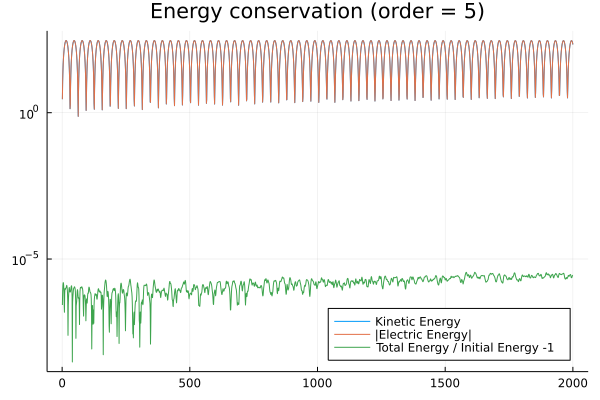

In [69]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) 
, yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png(run_name * "energy_conservation")

In [70]:
abs.(Energy_K[end]  + Energy_E[end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1])

2.7986544906721955e-6

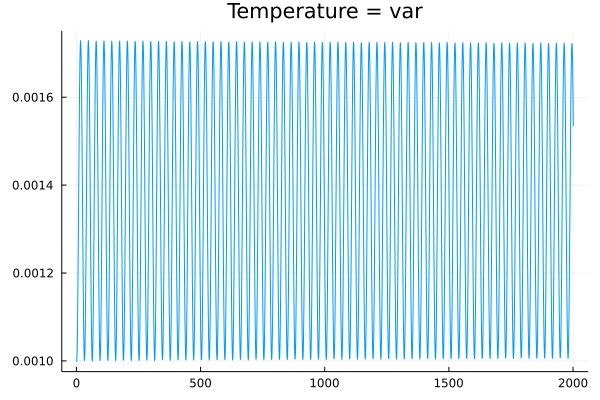

In [71]:
plot(T, label= "θ", title = "Temperature = var", legend = false)

#png(run_name * "temperature")

In [72]:
T[end]
#length(T)

0.00153416717801497

In [73]:
t_series = [dt*(i-1)*(M-1)/(M_g-1) for i in 1:M_g];

Since we are fitting the temperature and that is like the velocity square we need to approximate it with the square of a wave.

In [81]:
p0 = [0.001, 0.0001, 1.0, -0.0] #, 0.0, 0.0]
@. model(x, p) = p[1] + p[2]*cos(x*p[3] + p[4])^2 #*cos(x*p[5] + p[6])

model (generic function with 1 method)

In [82]:
fit = curve_fit(model, t_series, T, p0);
fit.param

4-element Vector{Float64}:
  0.0017258979422902973
 -0.0007228907770564346
  1.0001496598352457
 -3.1399059998824974

For these parámeters the fit is:

`[0.0017258979422902973,
 -0.0007228907770564346,
  1.0001496598352457,
 -3.1399059998824974]`


In [85]:
cov = estimate_covar(fit)

#sqrt(Diagonal(cov))

#margin_of_error = margin_error(fit, 0.1)


#confidence_intervals = confidence_interval(fit, 0.1)

4×4 Matrix{Float64}:
  2.20767e-15  -2.94447e-15   7.41979e-17  -1.00864e-14
 -2.94447e-15   5.90124e-15   4.20125e-17  -1.29548e-14
  7.41979e-17   4.20125e-17   8.49937e-13  -8.49403e-11
 -1.00864e-14  -1.29548e-14  -8.49403e-11   1.13183e-8

The cov matrix is:
 
 `2.20767e-15  -2.94447e-15   7.41979e-17  -1.00864e-14
 -2.94447e-15   5.90124e-15   4.20125e-17  -1.29548e-14
  7.41979e-17   4.20125e-17   8.49937e-13  -8.49403e-11
 -1.00864e-14  -1.29548e-14  -8.49403e-11   1.13183e-8`

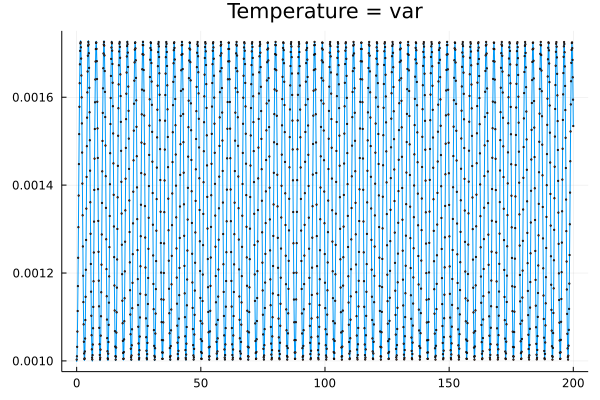

In [80]:
plot(t_series, T, label= "θ", title = "Temperature = var", legend = false)
scatter!(t_series, model(t_series, fit.param), markersize = 1)
#plot!(t_series, sum(T)/length(T) .+ 0.00019*cos.(2.0*t_series .- 3.))

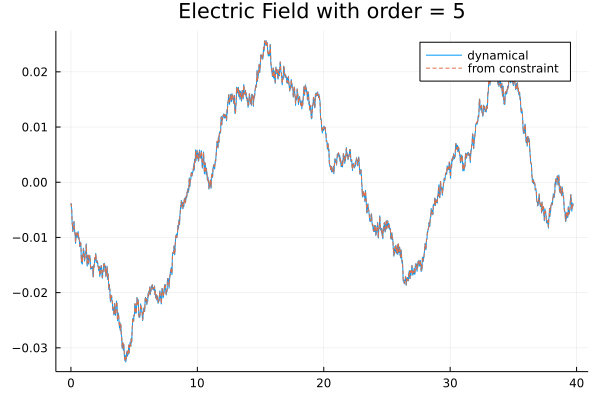

In [86]:
E_F = zeros(J)
ϕ_F = zeros(J)
#n_F = zeros(J)
#get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,E_f, label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png(run_name * "E")

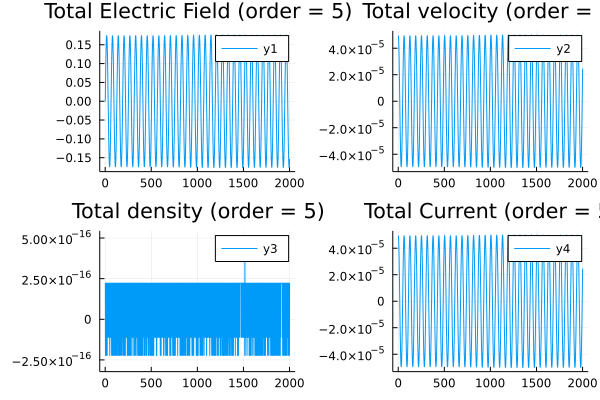

In [87]:
plot(layout=(2,2), title="order = $(order)")
plot!(subplot=1,E_T,title="Total Electric Field (order = $(order))")
plot!(subplot=2,v_T./N, title="Total velocity (order = $(order))")
plot!(subplot=3,D_T,title = "Total density (order = $(order))")
plot!(subplot=4,S_T,title = "Total Current (order = $(order))")
#png(run_name * "totals")

### Ahora chequeamos con dumping ###

In [8]:
#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_dumped_t100_L7.455_N2_5_J930_M1001_o5_T3th1_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");
(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_damped_t400_L7.455_N8_5_J930_M16001_o5_T3th4_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");
p
length(T)

16001

In [10]:
(L, N, J, κ, dx, order) = p

exp_Theta = 3 #this can be read from run_name
exp_t = 2 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = 0.0
t_f = 4*10.0^(exp_t)
M = 16001 #this can be read from run_name
M_g = 16000 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
t_i = 0.0

x = [dx*(i-1) for i in 1:J] ;

println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

animation = false



t_f = 400.0, M = 16001, dt = 0.025, exp_Theta = 3


false

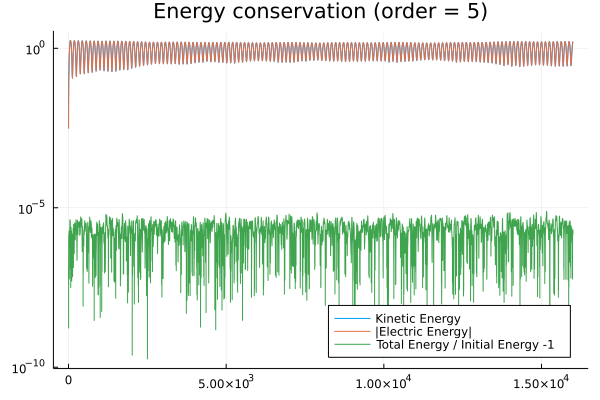

In [11]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) 
, yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png(run_name * "energy_conservation")

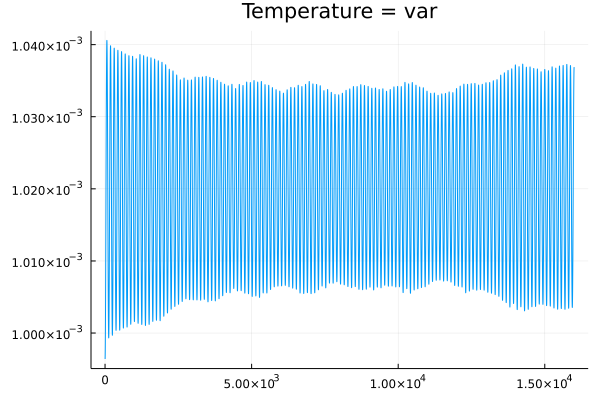

In [12]:
plot(T, label= "θ", title = "Temperature = var", legend = false)

In [13]:
t_series = [dt*(i-1)*(M-1)/(M_g-1) for i in 1:M_g];
Ttf = T .- sum(T)/length(T);

In [114]:
p0 = [0.001, 0.0001, 1.0, 0.0, 0.0001, 2.20, -0.1]
@. model(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]) + p[5]*cos(x*p[6] + p[7]))^2 #*cos(x*p[5] + p[6])

model (generic function with 1 method)

In [115]:
fit = curve_fit(model, t_series, T, p0);
fit.param

7-element Vector{Float64}:
  0.0010011050771356637
  0.0009859497968639065
  1.0072028940312805
 -1.5574348247681968
 -5.295963700924987e-6
  2.172896199459141
 -0.9772046654076538

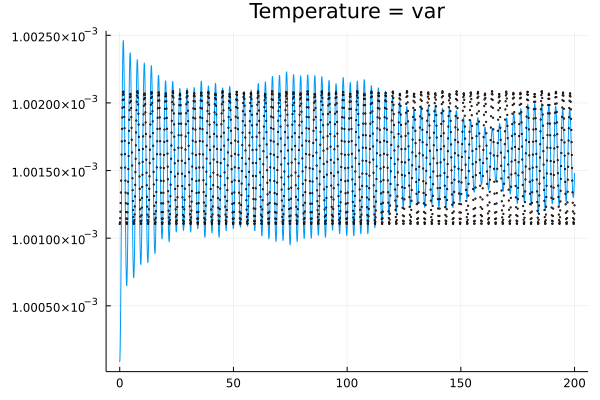

In [116]:
plot(t_series, T, label= "θ", title = "Temperature = var", legend = false)
scatter!(t_series, model(t_series, fit.param), markersize = 1)


In [99]:
0.0010338804563983137
  1.8802728365522955e-5
  2.0042597466066705
 -3.0318274127855513
 -0.003472672223301312


-0.003472672223301312

In [100]:
cov = estimate_covar(fit)

7×7 Matrix{Float64}:
  3.97606e-6  -5.73389e-5    2.55373e-7   …  -6.04772e-7    6.07976e-5
 -5.73389e-5   0.00170768   -5.25404e-6       1.59523e-5   -0.00160795
  2.55373e-7  -5.25404e-6    0.000193444     -7.86196e-8   -0.00015693
 -2.55043e-5   0.000521821  -0.0194374       -0.000156967   0.0325216
  8.19043e-6  -0.000758491  -1.15709e-6      -3.87137e-6    0.000394364
 -6.04772e-7   1.59523e-5   -7.86196e-8   …   0.00051618   -0.0521087
  6.07976e-5  -0.00160795   -0.00015693      -0.0521087     6.98189

In [ ]:
length(T)

In [ ]:
#plot(t_series, (T .- fit.param[1]).*exp.(-fit.param[5] .* t_series))
plot(t_series, Ttf.*exp.(0.0020769924816417553.* t_series))

In [ ]:
Th = rfft(Ttf.*exp.(0.0020769924816417553.* t_series))
Plots.scatter(real.(Th)
    ,xlim=(60,80)
    #,ylim=(-0.01,0.01)
    ,label=false
    )

In [ ]:
Plots.scatter(imag.(Th)
    ,xlim=(0,100)
    )

In [ ]:
E_F = zeros(J)
ϕ_F = zeros(J)
#n_F = zeros(J)
#get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,E_f, label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png(run_name * "E")

In [ ]:
plot(layout=(2,2), title="order = $(order)")
plot!(subplot=1,E_T,title="Total Electric Field (order = $(order))")
plot!(subplot=2,v_T./N, title="Total velocity (order = $(order))")
plot!(subplot=3,D_T,title = "Total density (order = $(order))")
plot!(subplot=4,S_T,title = "Total Current (order = $(order))")
#png(run_name * "totals")
